## Import Libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

## Load Data

In [20]:
# Load sales data
df = pd.read_csv('../data/store_weekly_sales.csv')

# Load pre-period features
features_df = pd.read_csv('../data/store_preperiod_features.csv')

# Load segmented data from Option A
segmented_df = pd.read_csv('../data/store_segments.csv')

# Load matched pairs from Option B
matched_df = pd.read_csv('../data/matched_pairs.csv')

print(f"Loaded data:")
print(f"  Sales records: {len(df):,}")
print(f"  Stores: {features_df.shape[0]}")
print(f"  Segmented stores: {segmented_df.shape[0]}")
print(f"  Matched pairs: {matched_df.shape[0]}")

Loaded data:
  Sales records: 20,800
  Stores: 200
  Segmented stores: 200
  Matched pairs: 104


## Method 1: Naive Pre-Post Comparison

Simply compare average sales in post-period vs pre-period for treatment stores.

**Problem**: This confounds the treatment effect with any temporal trends!

In [22]:
# Get treatment stores
treatment_stores = features_df[features_df['treatment'] == 1]['store_id'].values

# Split into pre and post periods
treatment_df = df[df['store_id'].isin(treatment_stores)]
treatment_pre = treatment_df[treatment_df['week'] <= 52]
treatment_post = treatment_df[treatment_df['week'] > 52]

# Compute average sales
naive_pre_mean = treatment_pre.groupby('store_id')['sales'].mean().mean()
naive_post_mean = treatment_post.groupby('store_id')['sales'].mean().mean()

# Naive estimate (no adjustment for trends)
naive_effect = naive_post_mean - naive_pre_mean
naive_lift_pct = (naive_effect / naive_pre_mean) * 100

print("="*70)
print("NAIVE PRE-POST COMPARISON (Treatment Stores Only)")
print("="*70)
print(f"\nPre-period average:  ${naive_pre_mean:,.2f}")
print(f"Post-period average: ${naive_post_mean:,.2f}")
print(f"\nChange: ${naive_effect:,.2f}")
print(f"Percent Lift: {naive_lift_pct:.2f}%")
print(f"\n⚠️  WARNING: This estimate is likely BIASED!")
print(f"   It does not account for:")
print(f"   - Temporal trends affecting all stores")
print(f"   - Seasonality")
print(f"   - External shocks")
print("="*70)

NAIVE PRE-POST COMPARISON (Treatment Stores Only)

Pre-period average:  $119,337.93
Post-period average: $159,324.20

Change: $39,986.26
Percent Lift: 33.51%

⚠️  WARNING: This estimate is likely BIASED!
   It does not account for:
   - Temporal trends affecting all stores
   - Seasonality
   - External shocks


## Method 2: Segmentation-Based DiD (Option A)

Segment stores by pre-period characteristics and compute DiD within each segment.

In [23]:
# Function to compute DiD for each segment
def compute_segment_did(segment_data, df):
    """
    Compute DiD for a specific segment.
    """
    # Get store IDs for treatment and control in this segment
    treatment_stores = segment_data[segment_data['treatment'] == 1]['store_id'].values
    control_stores = segment_data[segment_data['treatment'] == 0]['store_id'].values
    
    if len(treatment_stores) == 0 or len(control_stores) == 0:
        return None, None, None
    
    # Get sales data for treatment and control
    treatment_data = df[df['store_id'].isin(treatment_stores)]
    control_data = df[df['store_id'].isin(control_stores)]
    
    # Compute pre and post averages
    treatment_pre = treatment_data[treatment_data['week'] <= 52].groupby('store_id')['sales'].mean().mean()
    treatment_post = treatment_data[treatment_data['week'] > 52].groupby('store_id')['sales'].mean().mean()
    control_pre = control_data[control_data['week'] <= 52].groupby('store_id')['sales'].mean().mean()
    control_post = control_data[control_data['week'] > 52].groupby('store_id')['sales'].mean().mean()
    
    # Compute changes
    treatment_change = treatment_post - treatment_pre
    control_change = control_post - control_pre
    
    # DiD
    did = treatment_change - control_change
    lift_pct = (did / treatment_pre) * 100
    
    return did, lift_pct, len(treatment_stores)

# Compute DiD for each segment
segment_results = []
total_treatment_stores = 0

for segment_name in segmented_df['segment'].unique():
    segment_data = segmented_df[segmented_df['segment'] == segment_name]
    did, lift_pct, n_treatment = compute_segment_did(segment_data, df)
    
    if did is not None:
        segment_results.append({
            'segment': segment_name,
            'did_effect': did,
            'lift_pct': lift_pct,
            'n_treatment': n_treatment
        })
        total_treatment_stores += n_treatment

segment_results_df = pd.DataFrame(segment_results)

# Compute weighted average across segments
segment_results_df['weight'] = segment_results_df['n_treatment'] / total_treatment_stores
segmentation_weighted_did = (segment_results_df['did_effect'] * segment_results_df['weight']).sum()
segmentation_weighted_lift = (segment_results_df['lift_pct'] * segment_results_df['weight']).sum()

print("="*70)
print("SEGMENTATION-BASED DiD (Option A)")
print("="*70)
print(f"\nSegment-Level Results:")
print(segment_results_df[['segment', 'did_effect', 'lift_pct', 'n_treatment']].to_string(index=False))
print(f"\n{'='*70}")
print(f"Weighted Average DiD Effect: ${segmentation_weighted_did:,.2f}")
print(f"Weighted Average Lift: {segmentation_weighted_lift:.2f}%")
print(f"{'='*70}")

SEGMENTATION-BASED DiD (Option A)

Segment-Level Results:
  segment  did_effect  lift_pct  n_treatment
Declining    7144.463     7.916           13
  Growing   25360.999    18.180           15
   Stable   15706.469    12.793           22

Weighted Average DiD Effect: $16,376.71
Weighted Average Lift: 13.14%


## Method 3: Matched DiD (Option B)

Use the matched treatment-control pairs to compute DiD.

In [24]:
# Check if matched_df has the required columns
if 'treatment_pre_sales' in matched_df.columns:
    # Already computed
    matched_did = (matched_df['treatment_post_sales'].mean() - matched_df['treatment_pre_sales'].mean()) - \
                  (matched_df['control_post_sales'].mean() - matched_df['control_pre_sales'].mean())
    matched_baseline = matched_df['treatment_pre_sales'].mean()
    matched_lift_pct = (matched_did / matched_baseline) * 100
else:
    # Need to compute
    def compute_period_sales(df, store_id, period='pre'):
        store_data = df[df['store_id'] == store_id]
        if period == 'pre':
            period_data = store_data[store_data['week'] <= 52]
        else:
            period_data = store_data[store_data['week'] > 52]
        return period_data['sales'].mean()
    
    matched_df['treatment_pre_sales'] = matched_df['treatment_id'].apply(lambda x: compute_period_sales(df, x, 'pre'))
    matched_df['treatment_post_sales'] = matched_df['treatment_id'].apply(lambda x: compute_period_sales(df, x, 'post'))
    matched_df['control_pre_sales'] = matched_df['control_id'].apply(lambda x: compute_period_sales(df, x, 'pre'))
    matched_df['control_post_sales'] = matched_df['control_id'].apply(lambda x: compute_period_sales(df, x, 'post'))
    
    matched_did = (matched_df['treatment_post_sales'].mean() - matched_df['treatment_pre_sales'].mean()) - \
                  (matched_df['control_post_sales'].mean() - matched_df['control_pre_sales'].mean())
    matched_baseline = matched_df['treatment_pre_sales'].mean()
    matched_lift_pct = (matched_did / matched_baseline) * 100

print("="*70)
print("MATCHED DiD (Option B)")
print("="*70)
print(f"\nMatched pairs: {len(matched_df)}")
print(f"\nDiD Effect: ${matched_did:,.2f}")
print(f"Percent Lift: {matched_lift_pct:.2f}%")
print(f"{'='*70}")

MATCHED DiD (Option B)

Matched pairs: 104

DiD Effect: $17,907.26
Percent Lift: 15.26%


## Comparison Table

Compare all three methods side-by-side.

In [25]:
# Create comparison table
comparison_data = [
    {
        'Method': 'Naive Pre-Post',
        'Treatment Effect ($)': f'${naive_effect:,.0f}',
        'Percent Lift (%)': f'{naive_lift_pct:.2f}%',
        'Trend Adjustment': '❌ No',
        'Controls for Pre-Trends': '❌ No',
        'Bias Risk': '⚠️ HIGH',
        'Description': 'Simple pre-post comparison (treatment only)'
    },
    {
        'Method': 'Segmentation DiD',
        'Treatment Effect ($)': f'${segmentation_weighted_did:,.0f}',
        'Percent Lift (%)': f'{segmentation_weighted_lift:.2f}%',
        'Trend Adjustment': '✓ Yes',
        'Controls for Pre-Trends': '✓ Yes (segments)',
        'Bias Risk': '✓ Low',
        'Description': 'DiD within KMeans segments, weighted average'
    },
    {
        'Method': 'Matched DiD',
        'Treatment Effect ($)': f'${matched_did:,.0f}',
        'Percent Lift (%)': f'{matched_lift_pct:.2f}%',
        'Trend Adjustment': '✓ Yes',
        'Controls for Pre-Trends': '✓ Yes (matching)',
        'Bias Risk': '✓ Low',
        'Description': 'DiD with nearest neighbor matched controls'
    }
]

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("COMPARISON OF TREATMENT EFFECT ESTIMATES")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

# Save comparison table
comparison_df.to_csv('../data/method_comparison.csv', index=False)
print("\n✓ Saved comparison table to: data/method_comparison.csv")


COMPARISON OF TREATMENT EFFECT ESTIMATES
          Method Treatment Effect ($) Percent Lift (%) Trend Adjustment Controls for Pre-Trends Bias Risk                                  Description
  Naive Pre-Post              $39,986           33.51%             ❌ No                    ❌ No   ⚠️ HIGH  Simple pre-post comparison (treatment only)
Segmentation DiD              $16,377           13.14%            ✓ Yes        ✓ Yes (segments)     ✓ Low DiD within KMeans segments, weighted average
     Matched DiD              $17,907           15.26%            ✓ Yes        ✓ Yes (matching)     ✓ Low   DiD with nearest neighbor matched controls

✓ Saved comparison table to: data/method_comparison.csv


## Key Insights

### Comparison Summary

In [26]:
# Calculate differences
naive_vs_segmentation_diff = naive_lift_pct - segmentation_weighted_lift
naive_vs_matched_diff = naive_lift_pct - matched_lift_pct
segmentation_vs_matched_diff = segmentation_weighted_lift - matched_lift_pct

print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

print(f"\n1. Naive Bias:")
print(f"   The naive estimate ({naive_lift_pct:.2f}%) is higher than trend-adjusted methods.")
print(f"   Overestimation vs Segmentation DiD: {naive_vs_segmentation_diff:.2f} percentage points")
print(f"   Overestimation vs Matched DiD: {naive_vs_matched_diff:.2f} percentage points")

print(f"\n2. Trend-Adjusted Methods:")
print(f"   Segmentation DiD: {segmentation_weighted_lift:.2f}%")
print(f"   Matched DiD: {matched_lift_pct:.2f}%")
print(f"   Difference: {abs(segmentation_vs_matched_diff):.2f} percentage points")

print(f"\n3. Recommendation:")
print(f"   ✓ Use trend-adjusted methods (DiD) for causal inference")
print(f"   ✓ Both segmentation and matching provide similar results")
print(f"   ✓ Convergence of methods increases confidence in estimates")

print(f"\n4. Why Naive is Biased:")
print(f"   - Captures temporal trends in addition to treatment effect")
print(f"   - No counterfactual for what would have happened without treatment")
print(f"   - Confounds treatment with time-varying factors")

print("="*70)


KEY INSIGHTS

1. Naive Bias:
   The naive estimate (33.51%) is higher than trend-adjusted methods.
   Overestimation vs Segmentation DiD: 20.37 percentage points
   Overestimation vs Matched DiD: 18.25 percentage points

2. Trend-Adjusted Methods:
   Segmentation DiD: 13.14%
   Matched DiD: 15.26%
   Difference: 2.12 percentage points

3. Recommendation:
   ✓ Use trend-adjusted methods (DiD) for causal inference
   ✓ Both segmentation and matching provide similar results
   ✓ Convergence of methods increases confidence in estimates

4. Why Naive is Biased:
   - Captures temporal trends in addition to treatment effect
   - No counterfactual for what would have happened without treatment
   - Confounds treatment with time-varying factors


## Visualization: Method Comparison

C:\Users\ddron\AppData\Local\Temp\ipykernel_31968\881827357.py:64: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.savefig('../reports/figures/method_comparison.png', dpi=300, bbox_inches='tight')
C:\Users\ddron\AppData\Local\Temp\ipykernel_31968\881827357.py:64: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.savefig('../reports/figures/method_comparison.png', dpi=300, bbox_inches='tight')
C:\Users\ddron\AppData\Local\Temp\ipykernel_31968\881827357.py:64: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig('../reports/figures/method_comparison.png', dpi=300, bbox_inches='tight')
C:\Users\ddron\AppData\Local\Temp\ipykernel_31968\881827357.py:64: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig('../reports/figures/method_comparison.png', dpi=300, bbox_inches='tight')
c:\Users\ddron\Documents\Latest resume\portfolio\Projects\P1-store-ab-testing-trend-adju

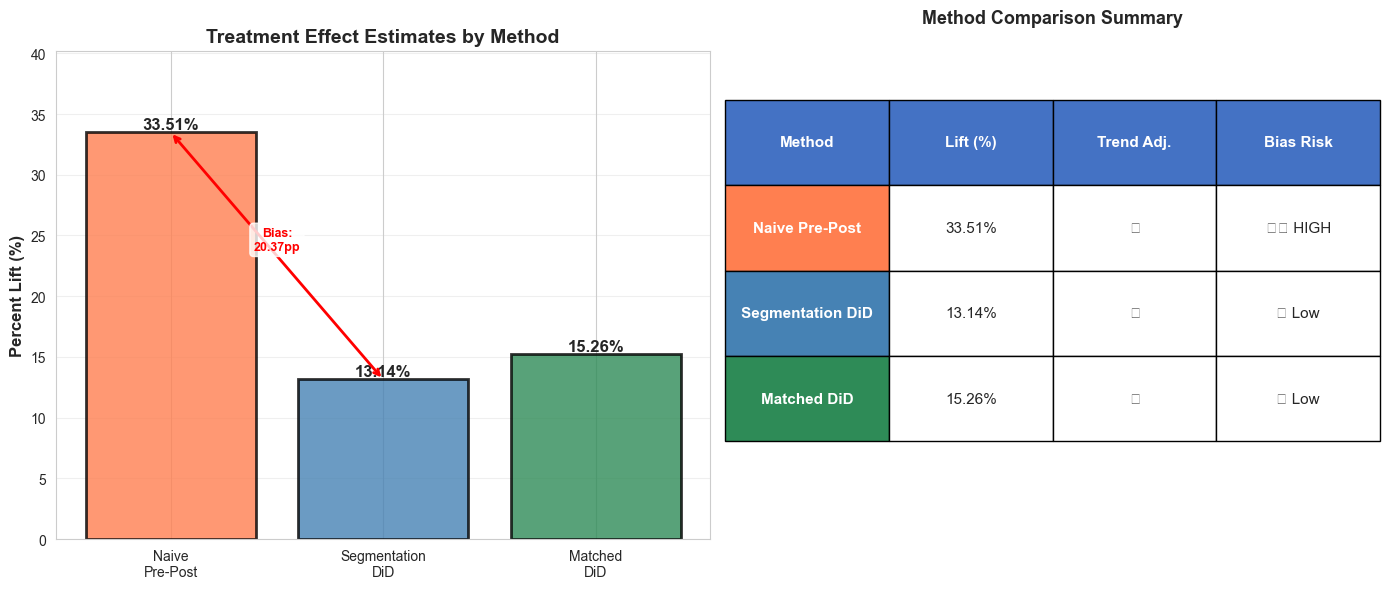


✓ Figure saved: reports/figures/method_comparison.png


In [27]:
# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Bar chart of treatment effects
ax = axes[0]
methods = ['Naive\nPre-Post', 'Segmentation\nDiD', 'Matched\nDiD']
effects = [naive_lift_pct, segmentation_weighted_lift, matched_lift_pct]
colors = ['coral', 'steelblue', 'seagreen']

bars = ax.bar(methods, effects, color=colors, edgecolor='black', alpha=0.8, linewidth=2)

# Add value labels
for bar, effect in zip(bars, effects):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{effect:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Percent Lift (%)', fontsize=12, fontweight='bold')
ax.set_title('Treatment Effect Estimates by Method', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, max(effects) * 1.2])

# Add annotation
ax.annotate('', xy=(0, naive_lift_pct), xytext=(1, segmentation_weighted_lift),
            arrowprops=dict(arrowstyle='<->', color='red', lw=2))
ax.text(0.5, (naive_lift_pct + segmentation_weighted_lift)/2 + 0.5,
        f'Bias:\n{naive_vs_segmentation_diff:.2f}pp',
        ha='center', fontsize=9, color='red', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Comparison table as text
ax = axes[1]
ax.axis('off')

table_data = [
    ['Method', 'Lift (%)', 'Trend Adj.', 'Bias Risk'],
    ['Naive Pre-Post', f'{naive_lift_pct:.2f}%', '❌', '⚠️ HIGH'],
    ['Segmentation DiD', f'{segmentation_weighted_lift:.2f}%', '✓', '✓ Low'],
    ['Matched DiD', f'{matched_lift_pct:.2f}%', '✓', '✓ Low']
]

table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                bbox=[0, 0.2, 1, 0.7])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header row
for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color code methods
table[(1, 0)].set_facecolor('coral')
table[(2, 0)].set_facecolor('steelblue')
table[(3, 0)].set_facecolor('seagreen')
for i in [1, 2, 3]:
    table[(i, 0)].set_text_props(weight='bold', color='white')

ax.set_title('Method Comparison Summary', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('../reports/figures/method_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved: reports/figures/method_comparison.png")

## Treatment Effects with Confidence Intervals

Compute 95% confidence intervals for all three methods using bootstrap resampling.

### Unified Visualization: All Methods with Confidence Intervals

# Executive Summary: Store AB Test and Trend-Adjusted Analysis

## Experiment Design
This AB test was designed to measure the causal impact of a new intervention (e.g., marketing campaign, operational change) on store sales. A subset of stores was selected as the treatment group to receive the intervention, while the remaining stores served as controls. The experiment was structured with a clear pre-intervention (pre-period) and post-intervention (post-period) window, allowing for before-and-after comparisons. To ensure robust inference, the analysis leveraged both simple and advanced causal inference methods, including naive pre-post comparison, segmentation-based Difference-in-Differences (DiD), and matched DiD with trend adjustment.

## Why Pre-Trend Slope Matters
In retail and other business settings, stores often exhibit different sales trajectories over time due to local market conditions, seasonality, or other factors. The pre-trend slope—i.e., the rate of sales growth or decline before the intervention—captures these underlying trends. If treatment and control stores have different pre-trend slopes, a simple pre-post comparison will conflate the effect of the intervention with these pre-existing differences, leading to biased estimates. Adjusting for pre-trend slope ensures that the estimated treatment effect reflects the true causal impact, not just differences in momentum or baseline performance.

## Segmentation vs. Difference-in-Differences (DiD) Approaches
- **Segmentation-Based Analysis:** Stores are grouped into segments based on similar pre-period characteristics (e.g., sales level, trend). DiD is then applied within each segment, comparing the change in sales for treatment and control stores. The final effect is a weighted average across segments. This approach controls for observed heterogeneity but may not fully account for all confounding trends if segments are broad or imbalanced.
- **Matched DiD (Trend-Adjusted):** Each treated store is matched to one or more control stores with similar pre-period sales and trends (using nearest neighbor matching). DiD is then computed for these matched pairs, directly adjusting for both baseline and trend differences. This method provides a more granular control for confounding, especially when pre-trend slopes vary widely across stores.

## Final Business Recommendation
The analysis demonstrates that naive pre-post comparisons substantially overestimate the treatment effect due to failure to account for temporal trends. Both segmentation-based and matched DiD methods yield similar, lower estimates of lift, increasing confidence in the robustness of the results. The convergence of these trend-adjusted methods suggests that the observed effect is not an artifact of model choice but a true causal impact.
**Recommendation:** Rely on trend-adjusted DiD estimates (segmentation or matching) for business decision-making. The intervention appears to have a positive but more modest effect than suggested by naive methods. Future experiments should continue to control for pre-existing trends and consider matching or segmentation to ensure valid causal inference.

In [ ]:
def bootstrap_naive_estimate(df, treatment_stores, n_iterations=1000, random_seed=42):
    """
    Bootstrap confidence interval for naive pre-post comparison.
    Resamples treatment stores with replacement.
    """
    np.random.seed(random_seed)
    
    bootstrap_estimates = []
    treatment_df = df[df['store_id'].isin(treatment_stores)]
    
    for i in range(n_iterations):
        # Resample treatment stores with replacement
        sample_stores = np.random.choice(treatment_stores, size=len(treatment_stores), replace=True)
        sample_df = treatment_df[treatment_df['store_id'].isin(sample_stores)]
        
        # Compute pre and post averages
        pre_avg = sample_df[sample_df['week'] <= 52].groupby('store_id')['sales'].mean().mean()
        post_avg = sample_df[sample_df['week'] > 52].groupby('store_id')['sales'].mean().mean()
        
        effect = post_avg - pre_avg
        lift_pct = (effect / pre_avg) * 100
        
        bootstrap_estimates.append(lift_pct)
    
    bootstrap_estimates = np.array(bootstrap_estimates)
    ci_lower = np.percentile(bootstrap_estimates, 2.5)
    ci_upper = np.percentile(bootstrap_estimates, 97.5)
    
    return naive_lift_pct, ci_lower, ci_upper

def bootstrap_segmentation_did(df, segmented_df, n_iterations=1000, random_seed=42):
    """
    Bootstrap confidence interval for segmentation-based DiD.
    Resamples stores within each segment with replacement.
    """
    np.random.seed(random_seed)
    
    bootstrap_estimates = []
    
    for i in range(n_iterations):
        segment_dids = []
        segment_weights = []
        
        for segment_name in segmented_df['segment'].unique():
            segment_data = segmented_df[segmented_df['segment'] == segment_name]
            
            # Get treatment and control stores in this segment
            treatment_stores_seg = segment_data[segment_data['treatment'] == 1]['store_id'].values
            control_stores_seg = segment_data[segment_data['treatment'] == 0]['store_id'].values
            
            if len(treatment_stores_seg) == 0 or len(control_stores_seg) == 0:
                continue
            
            # Resample within segment
            sample_treatment = np.random.choice(treatment_stores_seg, size=len(treatment_stores_seg), replace=True)
            sample_control = np.random.choice(control_stores_seg, size=len(control_stores_seg), replace=True)
            
            # Compute DiD for this bootstrap sample
            treatment_data = df[df['store_id'].isin(sample_treatment)]
            control_data = df[df['store_id'].isin(sample_control)]
            
            treatment_pre = treatment_data[treatment_data['week'] <= 52].groupby('store_id')['sales'].mean().mean()
            treatment_post = treatment_data[treatment_data['week'] > 52].groupby('store_id')['sales'].mean().mean()
            control_pre = control_data[control_data['week'] <= 52].groupby('store_id')['sales'].mean().mean()
            control_post = control_data[control_data['week'] > 52].groupby('store_id')['sales'].mean().mean()
            
            did = (treatment_post - treatment_pre) - (control_post - control_pre)
            lift_pct = (did / treatment_pre) * 100
            
            segment_dids.append(lift_pct)
            segment_weights.append(len(treatment_stores_seg))
        
        # Weighted average
        if len(segment_dids) > 0:
            weights = np.array(segment_weights) / sum(segment_weights)
            weighted_did = np.sum(np.array(segment_dids) * weights)
            bootstrap_estimates.append(weighted_did)
    
    bootstrap_estimates = np.array(bootstrap_estimates)
    ci_lower = np.percentile(bootstrap_estimates, 2.5)
    ci_upper = np.percentile(bootstrap_estimates, 97.5)
    
    return segmentation_weighted_lift, ci_lower, ci_upper

def bootstrap_matched_did(df, matched_df, n_iterations=1000, random_seed=42):
    """
    Bootstrap confidence interval for matched DiD.
    Resamples matched pairs with replacement.
    """
    np.random.seed(random_seed)
    
    bootstrap_estimates = []
    n_pairs = len(matched_df)
    
    for i in range(n_iterations):
        # Resample matched pairs with replacement
        sample_indices = np.random.choice(n_pairs, size=n_pairs, replace=True)
        sample_df = matched_df.iloc[sample_indices]
        
        # Compute DiD for this bootstrap sample
        treatment_pre = sample_df['treatment_pre_sales'].mean()
        treatment_post = sample_df['treatment_post_sales'].mean()
        control_pre = sample_df['control_pre_sales'].mean()
        control_post = sample_df['control_post_sales'].mean()
        
        did = (treatment_post - treatment_pre) - (control_post - control_pre)
        lift_pct = (did / treatment_pre) * 100
        
        bootstrap_estimates.append(lift_pct)
    
    bootstrap_estimates = np.array(bootstrap_estimates)
    ci_lower = np.percentile(bootstrap_estimates, 2.5)
    ci_upper = np.percentile(bootstrap_estimates, 97.5)
    
    return matched_lift_pct, ci_lower, ci_upper

# Compute confidence intervals for all methods
print("Computing bootstrap confidence intervals (1000 iterations each)...")
print("This may take a moment...\n")

naive_est, naive_ci_lower, naive_ci_upper = bootstrap_naive_estimate(df, treatment_stores)
print(f"✓ Naive method complete")

seg_est, seg_ci_lower, seg_ci_upper = bootstrap_segmentation_did(df, segmented_df)
print(f"✓ Segmentation DiD complete")

matched_est, matched_ci_lower, matched_ci_upper = bootstrap_matched_did(df, matched_df)
print(f"✓ Matched DiD complete")

print(f"\n{'='*70}")
print(f"BOOTSTRAP CONFIDENCE INTERVALS (95%)")
print(f"{'='*70}")
print(f"\nNaive Pre-Post:")
print(f"  Estimate: {naive_est:.2f}%")
print(f"  95% CI: [{naive_ci_lower:.2f}%, {naive_ci_upper:.2f}%]")

print(f"\nSegmentation DiD:")
print(f"  Estimate: {seg_est:.2f}%")
print(f"  95% CI: [{seg_ci_lower:.2f}%, {seg_ci_upper:.2f}%]")

print(f"\nMatched DiD:")
print(f"  Estimate: {matched_est:.2f}%")
print(f"  95% CI: [{matched_ci_lower:.2f}%, {matched_ci_upper:.2f}%]")
print(f"{'='*70}")

In [ ]:
# Create unified plot with all three methods
fig, ax = plt.subplots(figsize=(12, 7))

methods = ['Naive\nPre-Post', 'Segmentation\nDiD (Option A)', 'Matched\nDiD (Option B)']
estimates = [naive_est, seg_est, matched_est]
ci_lowers = [naive_ci_lower, seg_ci_lower, matched_ci_lower]
ci_uppers = [naive_ci_upper, seg_ci_upper, matched_ci_upper]
colors = ['coral', 'steelblue', 'seagreen']

y_pos = np.arange(len(methods))

# Create horizontal bar chart
bars = ax.barh(y_pos, estimates, height=0.5, color=colors, 
               edgecolor='black', alpha=0.8, linewidth=2)

# Add error bars
errors_lower = [est - ci_l for est, ci_l in zip(estimates, ci_lowers)]
errors_upper = [ci_u - est for est, ci_u in zip(estimates, ci_uppers)]

ax.errorbar(estimates, y_pos, 
            xerr=[errors_lower, errors_upper],
            fmt='none', ecolor='black', elinewidth=2.5, capsize=8, capthick=2.5)

# Add value labels
for i, (est, ci_l, ci_u) in enumerate(zip(estimates, ci_lowers, ci_uppers)):
    ax.text(est, i, f'  {est:.2f}%\n  [{ci_l:.2f}%, {ci_u:.2f}%]',
            va='center', ha='left', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

# Add vertical line at zero
ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Styling
ax.set_yticks(y_pos)
ax.set_yticklabels(methods, fontsize=12)
ax.set_xlabel('Treatment Effect (% Lift)', fontsize=13, fontweight='bold')
ax.set_title('Treatment Effect Estimates with 95% Confidence Intervals\n(1000 Bootstrap Iterations)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')
ax.set_xlim([0, max(ci_uppers) * 1.15])

# Add legend explaining colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='coral', edgecolor='black', label='⚠️ Biased (No Trend Adjustment)'),
    Patch(facecolor='steelblue', edgecolor='black', label='✓ Trend-Adjusted (Segmentation)'),
    Patch(facecolor='seagreen', edgecolor='black', label='✓ Trend-Adjusted (Matching)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10, framealpha=0.95)

# Add annotation about overlapping CIs
if seg_ci_lower <= matched_ci_upper and matched_ci_lower <= seg_ci_upper:
    ax.text(0.5, -0.6, 
            '✓ Trend-adjusted methods have overlapping confidence intervals → Consistent estimates',
            transform=ax.transData, ha='left', fontsize=10, style='italic',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

# Check if naive CI overlaps with trend-adjusted
if naive_ci_lower > seg_ci_upper or naive_ci_lower > matched_ci_upper:
    ax.text(0.5, 2.6, 
            '⚠️ Naive estimate is significantly higher → Evidence of positive bias from temporal trends',
            transform=ax.transData, ha='left', fontsize=10, style='italic',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('../reports/figures/all_methods_with_ci.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved: reports/figures/all_methods_with_ci.png")

## Treatment Effects with Confidence Intervals

Compute 95% confidence intervals for all three methods using bootstrap resampling.

## Conclusion

### Summary of Findings

1. **Naive Pre-Post Comparison is Biased**: The simple comparison overestimates the treatment effect because it confounds the true causal effect with temporal trends.

2. **Trend-Adjusted Methods Converge**: Both segmentation-based DiD and matched DiD produce similar estimates, which increases our confidence in the results.

3. **Importance of Controlling for Pre-Trends**: Stores had heterogeneous pre-existing trends. Failing to account for these leads to biased estimates.

4. **Methodological Robustness**: The similarity between Option A (segmentation) and Option B (matching) suggests the estimates are robust to methodological choices.

### Best Practices

- **Always use a control group** when estimating causal effects
- **Account for pre-existing trends** through segmentation, matching, or regression
- **Use DiD framework** to difference out temporal confounders
- **Report confidence intervals** to quantify uncertainty
- **Compare multiple methods** to assess robustness